In [1]:
print("Importing misc libraries")
import sys
import os
import torch
#import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

print("Updating sys.path")
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
print("Importing torch libraries")
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
    
print("Importing unet lib")
import importlib
import vit.Vit as v
importlib.reload(v)

print("Importing dataset lib")
from dataset.IntersectionDataset import IntersectionDataset, IntersectionDataset2, IntersectionDatasetClasses, custom_collate_fn
import loss.loss_lib as ll
importlib.reload(ll)

# dataset_dir = "../../dataset/dataset/train"
# img_transform = ToTensor()
# path_transform = ToTensor()
# dataset_train = IntersectionDatasetClasses(root_dir=dataset_dir, 
#                                     transform=img_transform,
#                                     path_transform=path_transform)

dataset_dir = "../../dataset/dataset/test"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_test = IntersectionDatasetClasses(root_dir=dataset_dir,
                                   transform=img_transform,
                                   path_transform=path_transform)
# print(len(dataset_train))
print(len(dataset_test))

num_workers = multiprocessing.cpu_count()
b = 1

# train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)

Importing misc libraries
Updating sys.path
Importing torch libraries
Importing unet lib
Importing dataset lib
32


In [2]:
ckpt_path = "ckpt/c_vitskip_04_11_195_ce_adamw_exp.pth"
ckpt = torch.load(ckpt_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = v.ViTWithSkip().to(device) #num_layers=6, num_heads=6, hidden_dim=384, mlp_dim=768
model.load_state_dict(ckpt['model_state_dict'])
model.eval()
print()

/home/iduck/.msc_venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [4]:
for batch in test_dataloader:
    satellite = batch['satellite'].to(device)
    class_labels = batch['class_labels'].to(device)
    break

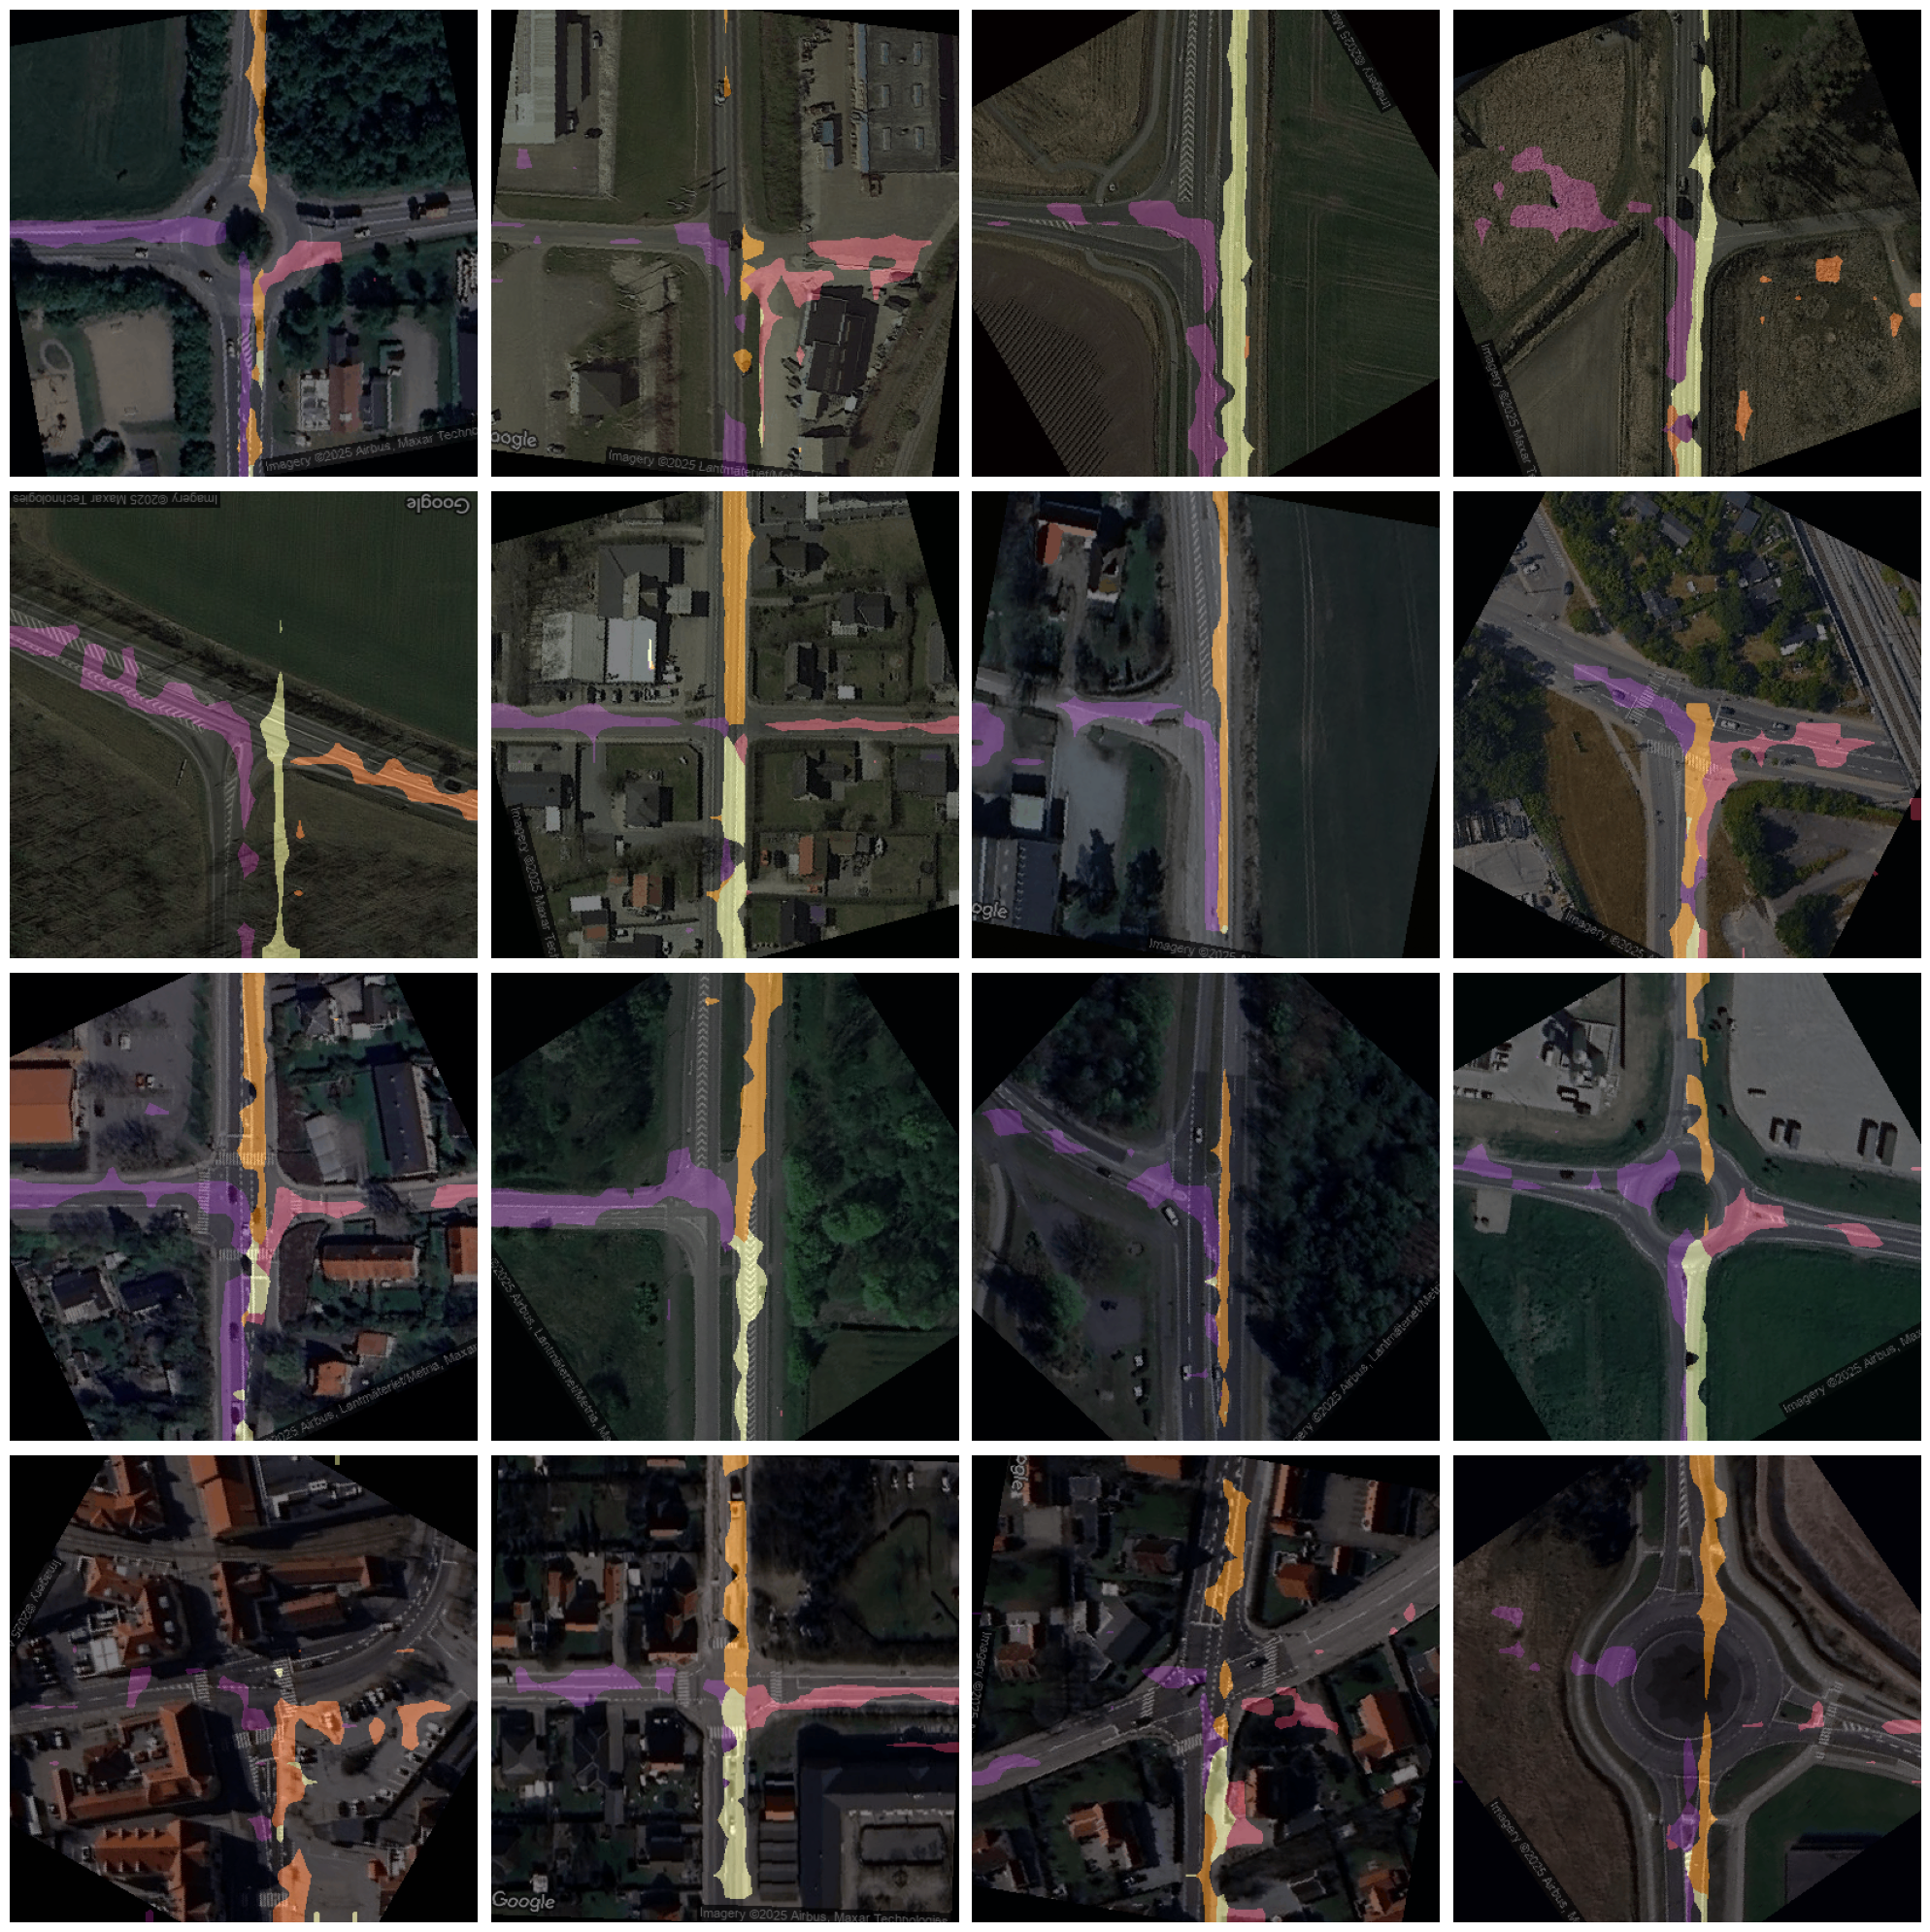

In [4]:
rows, cols = 4, 4
rc_ratio = rows / cols
if rc_ratio > 1:
    fig_width = 20
    fig_height = fig_width / rc_ratio
else:
    fig_height = 20
    fig_width = fig_height * rc_ratio

fig = plt.figure(figsize=(fig_width, fig_height))

i = 0
while i < rows * cols:
    satellite = test_dataloader.dataset[i]['satellite'].to(device)
    
    i += 1
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(satellite.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    
    output = model(satellite.unsqueeze(0))
    output = torch.argmax(output, dim=1)
    output = output.squeeze(0).cpu().numpy()
    
    #i += 1
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(output, cmap='inferno', alpha=0.5)
    plt.axis('off')

    #i += 1
    
fig.tight_layout()

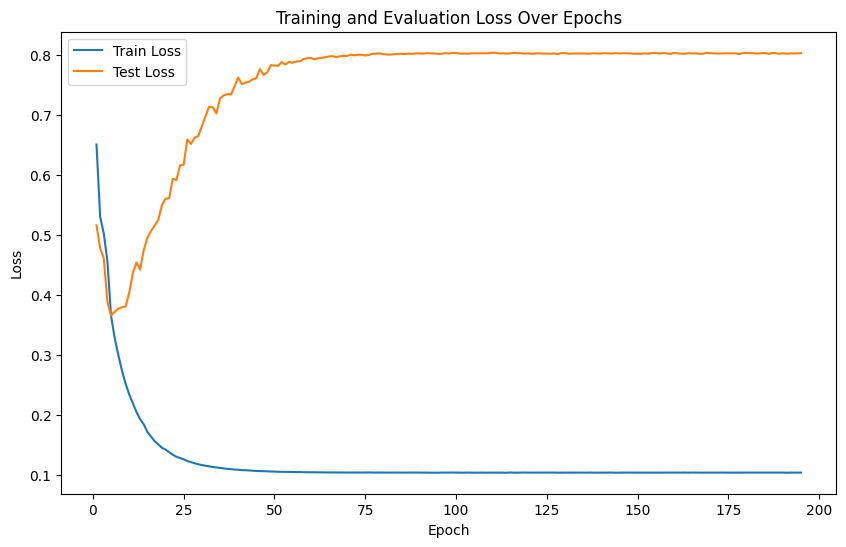

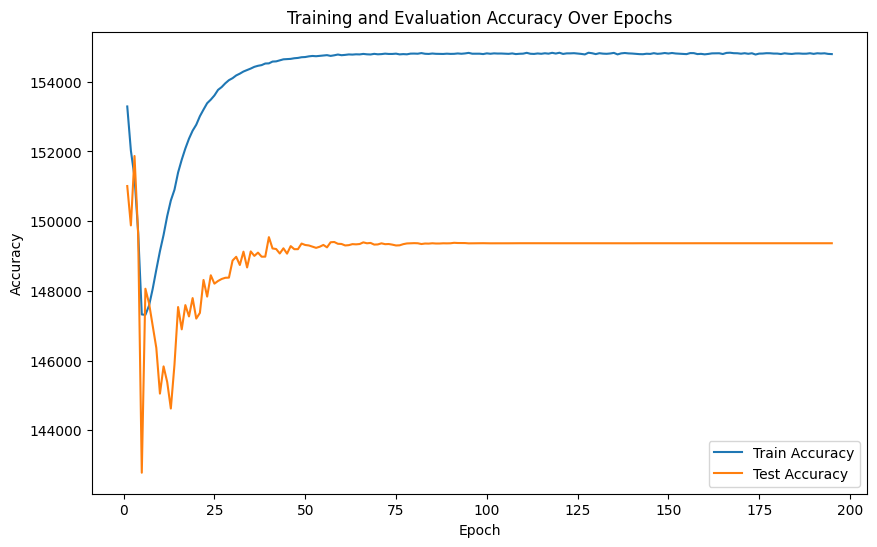

In [3]:
#ckpt_path = "ckpt/c_04_10_15_ce_cos.pth"
#ckpt = torch.load(ckpt_path)

n_epochs = len(ckpt['train_losses'])
train_losses = ckpt['train_losses']
test_losses = ckpt['test_losses']
train_accuracies = ckpt['train_accuracies']
test_accuracies = ckpt['test_accuracies']
# Plotting the loss graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# Plotting the accuracy graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, n_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Evaluation Accuracy Over Epochs")
plt.legend()
plt.show()